2018.10.27: Multiple states: Time series

In [1]:
import sys,os
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting parameter:
np.random.seed(1)

n = 10 # number of positions
m = 3 # number of values at each position
l = 1000 # number of samples

g = 1.

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

i1tab,i2tab = itab(n,m)

In [4]:
# generate coupling matrix w0:
def generate_coupling(n,m,g):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,:] -= w[i1:i2,:].mean(axis=0)            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            
        
    return w

In [5]:
w0 = generate_coupling(n,m,g)
"""
plt.figure(figsize=(3,3))
plt.title('actual coupling matrix')
plt.imshow(w0,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.3,0.3)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.3,0,0.3])
plt.show()
"""

"\nplt.figure(figsize=(3,3))\nplt.title('actual coupling matrix')\nplt.imshow(w0,cmap='rainbow',origin='lower')\nplt.xlabel('j')\nplt.ylabel('i')\nplt.clim(-0.3,0.3)\nplt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.3,0,0.3])\nplt.show()\n"

In [6]:
# 2018.10.27: generate sequences: time series
def generate_sequences(w,n,m,l): 
    #print(i1tab,i2tab)
    
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values
    #print(s_ini)

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()
    #print(s) 

    ntrial = 100

    for t in range(l-1):
        h = np.sum(s[t,:]*w[:,:],axis=1)
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]
    
            p1 = np.exp(h[i1:i2])
            p = p1/p1.sum()

            for itrial in range(ntrial):
                k = np.random.randint(0,m)
                if p[k] > np.random.rand():
                    s[t+1,i1:i2] = 0.
                    s[t+1,i1+k] = 1.
                break
            
            """
            if p[0] > np.random.rand():
                s[t+1,i1] = 1.
                s[t+1,i1+1] = 0.
            else:
                s[t+1,i1] = 0.
                s[t+1,i1] = 1.                                
            """
    return s            

In [7]:
s = generate_sequences(w0,n,m,l) 

In [8]:
print(s[:5])

[[0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
  0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
  1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
  0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 1.]]


In [9]:
def fit_increment(s,n,m):
    l = s.shape[0]
    
    s_av = np.mean(s[:-1],axis=0)
    ds = s[:-1] - s_av
    c = np.cov(ds,rowvar=False,bias=True)
    #print(c)

    c_inv = linalg.pinv(c,rcond=1e-15)
    #print(c_inv)

    nm = n*m
    wini = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    #print(w)

    nloop = 100
    w_infer = np.zeros((nm,nm))

    for i in range(n):
        #print(i)
        i1,i2 = i1tab[i],i2tab[i]
        #s1 = np.copy(s[1:,i1:i2])

        w = wini[i1:i2,:]
        h = s[1:,i1:i2]
        for iloop in range(nloop):
            h_av = h.mean(axis=0)
            dh = h - h_av

            dhds = dh[:,:,np.newaxis]*ds[:,np.newaxis,:]
            dhds_av = dhds.mean(axis=0)

            w = np.dot(dhds_av,c_inv)

            h = np.dot(s[:-1],w.T)

            p = np.exp(h)
            p_sum = p.sum(axis=1)

            for k in range(m):
                p[:,k] = p[:,k]/p_sum[:]

            h += s[1:,i1:i2] - p

            #h += s[1:,i1:i2]/p
            #cost = ((s[1:,i1:i2]-p)**2).mean(axis=0)
            #print(i,iloop,cost)

            #w = w - w.mean(axis=0)    
        w_infer[i1:i2,:] = w     
    return w_infer

In [10]:
#w1 = fit_increment(s,n,m)

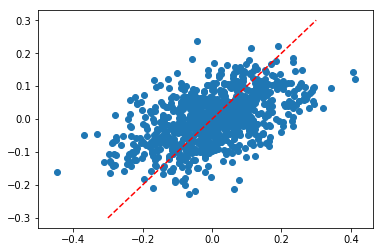

In [11]:
plt.scatter(w0,w1)
plt.plot([-0.3,0.3],[-0.3,0.3],'r--')